In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(rc={'figure.figsize': [14, 8]})

import logging
import pickle
from tqdm.auto import tqdm

import ast
import penman
import re
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from scipy.stats import fisher_exact
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from utils import categories

In [2]:
%%time
converters = {
    'amr_penman': ast.literal_eval,
    'amr_top_triples': ast.literal_eval,
    'amr_instances': ast.literal_eval,
}
df = pd.read_csv('data/LOCO/LOCO10k_with_AMR.csv', converters=converters)
df.head(2)

CPU times: user 25.4 s, sys: 597 ms, total: 26 s
Wall time: 26.3 s


,Unnamed: 0,doc_id,URL,website,seeds,date,subcorpus,title,txt,txt_nwords,...,topic_k300,mention_conspiracy,conspiracy_representative,cosine_similarity,FB_shares,FB_comments,FB_reactions,amr_penman,amr_top_triples,amr_instances
0,23258,C07120,https://oye.news/news/world-news/tanzania-pres...,oye.news,aids; covid.19; new.world.order,2020-05-06,conspiracy,Tanzania President Tested New CV-19 Test Kits ...,President Magufuli says tests were found to be...,249,...,k300_27,0,0.0,0.1138,17.0,11.0,44.0,[# ::snt President Magufuli says tests were fo...,"[(person, say-01, find-02), (thing, exemplify-...","[[say-01, person, name, have-org-role-91, pres..."
1,70403,M179e0,https://www.independent.co.uk/news/world/ameri...,independent.co.uk,september.11.attack,2018-09-09,mainstream,New York subway station destroyed in 9/11 reop...,"After almost two decades out of action, a New ...",410,...,k300_72,0,NaN,NaN,67.0,115.0,617.0,[# ::snt After almost two decades out of actio...,"[(, reopen-01, station), (, bury-01, street), ...","[[reopen-01, station, subway, city, name, dest..."


In [3]:
def parse_triplet(triplet):
    assert len(triplet) == 1
    triplet = triplet[0]
    return triplet[0], re.sub(r'-\d+', '', triplet[2])

In [4]:
def get_instance(graph, source):
    instance = graph._filter_triples(source=source, role=':instance', target=None)
    source, instance = parse_triplet(instance)
    if instance == 'person':
        for child in graph.edges(source=source):
            if child.role == ':name':
                attributes = graph.attributes(source=child.target)
                if attributes:
                    name = [re.sub(r'"', '', a.target) for a in attributes]
                    name = ' '.join(name)
                    instance = f'{instance} [{name}]'
    return instance

In [5]:
def extract_frames(graph, add_incomplete_frames=False):
    all_frames = []
    for arg0 in graph.edges(role=':ARG0'):
        frame = []
        frame.append(get_instance(graph, arg0.target))
        frame.append(get_instance(graph, arg0.source))
        arg1 = graph.edges(source=arg0.source, role=':ARG1')
        depth = 0
        while arg1:
            depth += 1
            arg1 = arg1[0]
            frame.append(get_instance(graph, arg1.target))
            if depth > 3:
                break
            arg1 = graph.edges(source=arg1.target, role=':ARG1')
            if add_incomplete_frames and arg1:
                all_frames.append(' '.join(frame.copy()))
        all_frames.append(' '.join(frame.copy()))
    return all_frames

In [6]:
def extract_frames_document(amr_penman):
    document_frames = []
    for pm in amr_penman:
        try:
            pm = re.sub(f'^# ::snt[^A-Za-z]+', '# ::snt ', pm)
            pm = re.sub(f'(\r\n)+', '', pm)
            graph = penman.decode(pm)
            document_frames.extend(extract_frames(graph, add_incomplete_frames=True))
        except (penman.DecodeError, TypeError):
            error_amrs.append(pm)
    return document_frames

In [7]:
idx = 0
print(df.txt[idx])
print(df.amr_penman[idx][0])
print(penman.parse(df.amr_penman[idx][0]))
extract_frames_document(df.amr_penman[idx])

President Magufuli says tests were found to be faulty after goat, sheep and pawpaw[fruit] samples test positive for COVID-19.

Quite an entertaining example of why these COVID19 test kits should be largely dismissed. While these types of examples continually get dismissed as faulty batches, you have to wonder if there are any good batches of test kits out there.

They had randomly obtained several non-human samples, including from a pawpaw, a goat and a sheep, but had assigned them human names and ages. These samples were then submitted to Tanzania’s laboratory to test for the coronavirus, with the lab technicians left deliberately unaware of their origins. Samples from the pawpaw and the goat tested positive for COVID-19, the president said, adding this meant it was likely that some people were being tested positive when, in fact, they were not infected by the coronavirus. “There is something happening. I said before we should not accept that every aid is meant to be good for this nat

['person [Magufuli] say find',
 'person [Magufuli] say find fault',
 'person [Magufuli] say find fault test',
 'person [Magufuli] have-org-role',
 'thing exemplify',
 'thing cause recommend',
 'thing cause recommend dismiss',
 'thing cause recommend dismiss kit',
 'exemplify entertain',
 'you wonder truth-value',
 'they obtain sample',
 'they assign and',
 'thing test coronavirus',
 'technician realize origin',
 'person say test',
 'person say test and',
 'person have-org-role',
 'person add mean',
 'person add mean test',
 'person add mean test and',
 'person [Magufuli] say say',
 'person [Magufuli] say say recommend',
 'person [Magufuli] say say recommend accept',
 'person [Magufuli] say say recommend accept mean',
 'person [Magufuli] add recommend',
 'person [Magufuli] add recommend investigate',
 'person [Magufuli] add recommend investigate kit',
 'person [Magufuli] say recommend',
 'person [Magufuli] say recommend accept',
 'person [Magufuli] say recommend accept mean',
 'person [

In [8]:
for i in range(9, 12):
    pm = df.amr_penman[idx][i]
    pm = re.sub(f'^# ::snt[^A-Za-z]+', '# ::snt ', pm)
    pm = re.sub(f'(\r\n)+', '', pm)
    graph = penman.decode(pm)
    print(extract_frames(graph, add_incomplete_frames=True))
    print()

['you care thing', 'you eat thing', 'you need concern', 'you need concern you', 'thing concern you']

['nothing safe', 'test cause safe']

['you trust test']



In [9]:
with open('data/LOCO/AMR_triples.pickle', 'rb') as f:
    all_triples = pickle.load(f)
with open('data/LOCO/AMR_errors.pickle', 'rb') as f:
    error_amrs = pickle.load(f)
print(len(error_amrs), 'errors')

3936 errors


# Analysis of Triples

In [10]:
flattened_triples = []
for triples in all_triples:
    flattened_triples.extend(triples)
print(len(flattened_triples), 'total triples')

1392821 total triples


In [11]:
unique_triples, unique_triple_counts = np.unique(flattened_triples, return_counts=True)
print(len(unique_triples), 'unique triples')

991344 unique triples


Average number of occurrences: 1.4049825287690247


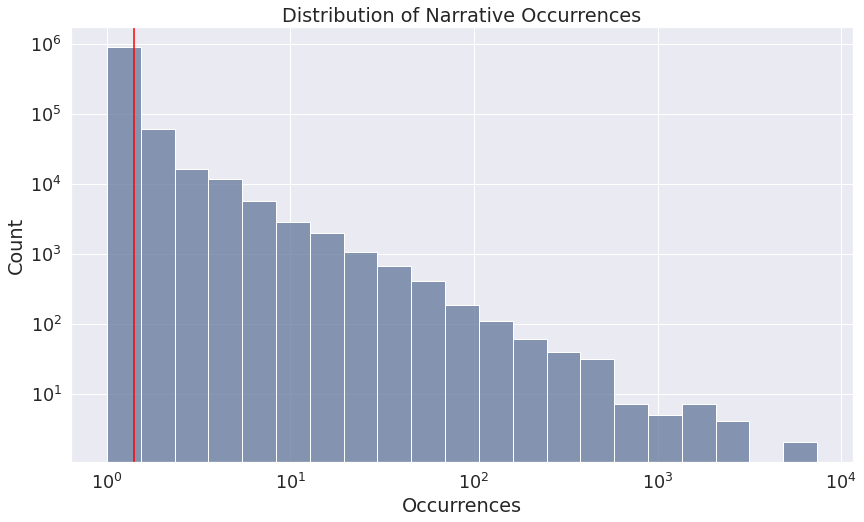

In [12]:
avg_num_occurrences = np.mean(unique_triple_counts)
print(f'Average number of occurrences: {avg_num_occurrences}')
sns.set(font_scale=1.6)
sns.histplot(unique_triple_counts, log_scale=(True, True), color='#62779a').set(title='Distribution of Narrative Occurrences', xlabel='Occurrences')
plt.axvline(avg_num_occurrences, color='red')
#plt.savefig('figures/narrative_distribution.pdf')

In [13]:
threshold = 10
print(np.sum(unique_triple_counts > threshold), f'triples ocurring more than {threshold} times')

5598 triples ocurring more than 10 times


In [14]:
order = np.argsort(unique_triple_counts)[::-1]
for i in range(30):
    print(unique_triples[order[i]])

government-organization govern
person have-org-role
person have-rel-role
person have-org-role government-organization
person research
government-organization govern country
person have-rel-role person
person work
person have-org-role country
government-organization administrate
person have-org-role political-party
person have-rel-role you
person study
person have-org-role organization
person have-rel-role i
person have-rel-role he
person live
person consume
person lead
person act
person report
person farm
person author
person have-org-role military
person [Trump] have-org-role
disease cause die
he say and
person have disease
person vote
person have-rel-role she


In [15]:
%%time
df_triples = pd.DataFrame(columns=unique_triples[unique_triple_counts > threshold], index=np.arange(len(all_triples)))
for i in range(len(all_triples)):
    tmp_triples = [triple for triple in all_triples[i] if triple in df_triples.columns]
    tmp_triples, tmp_triple_counts = np.unique(tmp_triples, return_counts=True)
    df_triples.loc[i, tmp_triples] = tmp_triple_counts
df_triples = df_triples.fillna(0)

CPU times: user 32.8 s, sys: 457 ms, total: 33.3 s
Wall time: 33.3 s


In [16]:
assert np.sum(df_triples.sum()) == unique_triple_counts[unique_triple_counts > threshold].sum()

In [17]:
(df_triples != 0).sum().sort_values(ascending=False)

person have-org-role                            2877
government-organization govern                  2844
person have-rel-role                            1383
person have-org-role government-organization    1381
government-organization govern country          1332
                                                ... 
human feel know feel know                          1
government-organization register wipe              1
person analyze information                         1
person have-rel-role person [Madonna]              1
human feel know feel                               1
Length: 5598, dtype: int64

[Text(0.5, 1.0, 'Document-Occurrences per Triple')]

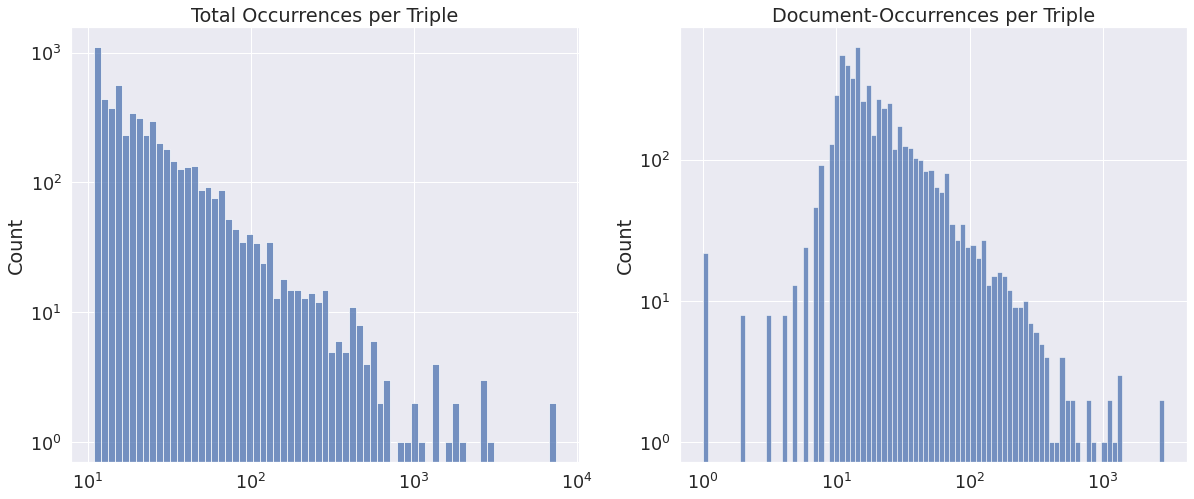

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(df_triples.sum(), log_scale=(True, True), ax=axs[0]).set(title='Total Occurrences per Triple')
sns.histplot((df_triples != 0).sum(), log_scale=(True, True), ax=axs[1]).set(title='Document-Occurrences per Triple')

Total occurrences is a power-law distribution. The number of triples occurring only in a few (less than 50) documents is however fairly small.

In [19]:
tfidftransformer = TfidfTransformer()
tfidf = tfidftransformer.fit_transform(df_triples)

In [20]:
df_tfidf = pd.DataFrame(tfidf.todense(), columns=tfidftransformer.feature_names_in_)
df_tfidf.head(2)

,accident cause die,act lead,activist oppose abort,activity cause warm,adolescent identify adolescent,adult have disease,adult live,affect devastate,affect negative,agency aid,...,you watch video,you wear mask,you will,you win,you wish use,you wish use material,you wonder thing,you work,you worry,you write
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df_tfidf.sum().sort_values(ascending=False)[:20]

government-organization govern                  447.844325
person have-org-role                            418.236507
person research                                 267.236269
person have-rel-role                            230.397839
government-organization govern country          210.166778
person have-org-role government-organization    199.208830
person have-org-role country                    160.256316
person have-rel-role person                     152.274553
person work                                     146.261968
government-organization administrate            145.729853
person study                                    132.982059
person have-org-role political-party            132.181014
person have-org-role organization               122.040665
person have-rel-role you                        114.304288
person have-rel-role he                         107.045642
person consume                                   99.546187
person have-rel-role i                           97.3106

# Frames

In [22]:
categories

['Capacity_and_resources',
 'Crime_and_punishment',
 'Cultural_identity',
 'Economic',
 'External_regulation_and_reputation',
 'Fairness_and_equality',
 'Health_and_safety',
 'Legality_Constitutionality_and_jurisprudence',
 'Morality',
 'Policy_prescription_and_evaluation',
 'Political',
 'Public_opinion',
 'Quality_of_life',
 'Security_and_defense']

In [23]:
with open('data/LOCO/loco_predictions.pickle', 'rb') as f:
    frames = pickle.load(f)
df_frames = pd.DataFrame(frames, columns=categories, index=df.index, dtype=np.int32)

In [24]:
cooccurrences = df_frames.to_numpy().T.dot(df_triples.to_numpy())
cooccurrences.shape

(14, 5598)

In [25]:
most_cooccurring_with_crime_and_punishment = np.argsort(cooccurrences[1])[::-1]
df_triples.columns[most_cooccurring_with_crime_and_punishment[:30]]

Index(['person have-org-role', 'government-organization govern',
       'person have-org-role government-organization',
       'government-organization govern country',
       'person have-org-role country', 'person have-rel-role',
       'person have-rel-role person', 'government-organization administrate',
       'person have-rel-role he', 'person have-org-role organization',
       'person study', 'person have-org-role political-party', 'person work',
       'person prosecute', 'person have-rel-role i',
       'person have-org-role military', 'person report', 'person act',
       'person investigate', 'person research', 'person have-org-role family',
       'person live', 'person witness', 'person have-rel-role she',
       'person [Trump] have-org-role', 'person shoot', 'person lead',
       'person pilot', 'person hijack', 'he say and'],
      dtype='object')

In [26]:
cooccurrences_tfidf = df_frames.to_numpy().T.dot(df_tfidf.to_numpy())
cooccurrences_tfidf.shape

(14, 5598)

In [27]:
most_cooccurring_with_crime_and_punishment_tfidf = np.argsort(cooccurrences_tfidf[1])[::-1]
df_triples.columns[most_cooccurring_with_crime_and_punishment_tfidf[:30]]

Index(['person have-org-role', 'government-organization govern',
       'person have-org-role government-organization',
       'government-organization govern country',
       'person have-org-role country', 'person have-rel-role person',
       'person have-rel-role he', 'person prosecute',
       'government-organization administrate', 'person have-rel-role',
       'person study', 'person have-org-role organization',
       'person have-org-role military', 'person have-org-role political-party',
       'person sing', 'person investigate', 'person act', 'person report',
       'person have-rel-role she', 'person witness', 'person work',
       'person have-org-role family', 'terrorist attack',
       'person have-rel-role i', 'person judge', 'person shoot',
       'person hijack', 'person pilot', 'person [Trump] have-org-role',
       'person live'],
      dtype='object')

## Logistic Regression

In [28]:
lr = LogisticRegression(fit_intercept=False)
lr.fit(X=df_tfidf, y=df_frames.Crime_and_punishment)
crime_and_punishment_max_coefficients = np.argsort(lr.coef_)[::-1]
df_triples.columns[crime_and_punishment_max_coefficients[0,:30]]

Index(['person research', 'disease infect', 'person consume',
       'person have-rel-role you', 'disease cause die', 'person have disease',
       'person work health', 'person lead world',
       'doctor have-org-role organization', 'person participate',
       'person travel', 'we work', 'and publication',
       'person have-org-role health', 'person work', 'person volunteer',
       'person have-rel-role', 'you risk', 'tooth decay', 'person observe',
       'person engineer', 'person live disease', 'virus cause disease',
       'publication describe and', 'person farm', 'vaccine effective',
       'product have and', 'person visit', 'change impact',
       'organization meet'],
      dtype='object')

In [29]:
lr = LogisticRegression(fit_intercept=False)
lr.fit(X=df_tfidf, y=df_frames.Health_and_safety)
health_and_safety_max_coefficients = np.argsort(lr.coef_)[::-1]
df_triples.columns[health_and_safety_max_coefficients[0,:30]]

Index(['person observe', 'person [Obama] have-org-role', 'person believe',
       'person rebel', 'you join person [Greg Hunter]',
       'person [Bush] have-org-role', 'person hijack',
       'person have-org-role criminal-organization',
       'person have-org-role country', 'country war country', 'person perform',
       'person have-org-role military', 'person lead criminal-organization',
       'person think', 'terrorist attack', 'planet orbit',
       'person [Saddam Hussein] have-org-role country', 'person act',
       'person serve', 'we search', 'person trade', 'person engineer',
       'person deal', 'person have-rel-role person [Diana]',
       'person prosecute', 'country policy', 'person immigrate',
       'person have-org-role political-party', 'person judge',
       'person [George W. Bush] have-org-role'],
      dtype='object')

In [30]:
lr = LogisticRegression(fit_intercept=False)
lr.fit(X=df_tfidf, y=df_frames.Fairness_and_equality)
fairness_and_equality_max_coefficients = np.argsort(lr.coef_)[::-1]
df_triples.columns[fairness_and_equality_max_coefficients[0,:30]]

Index(['person research', 'disease infect', 'person farm',
       'person have-rel-role you', 'person have disease', 'person consume',
       'person sing', 'person invest', 'disease cause die', 'person travel',
       'person respond', 'person have-org-role government-organization',
       'tooth decay', 'you go', 'person [Trump] have-org-role',
       'government-organization govern', 'you join person [Greg Hunter]',
       'person have-org-role health', 'government-organization govern country',
       'person visit', 'person drive', 'person pilot', 'person risk',
       'publication byline', 'person have-rel-role', 'person analyze',
       'vaccine effective', 'company make drug', 'person volunteer',
       'he say contrast'],
      dtype='object')

## Filtering

In [31]:
df_triples_clean = df_triples.drop(df_triples.filter(regex='^person', axis='columns').columns, axis='columns')
print(len(df_triples_clean.columns), 'columns')

3900 columns


In [32]:
lr = LogisticRegression(fit_intercept=False)
lr.fit(X=df_triples_clean, y=df_frames.Political)
max_coefficients = np.argsort(lr.coef_)[::-1]
df_triples_clean.columns[max_coefficients[0,:30]]

Index(['organization partner', 'and help and', 'and provide and',
       'virus cause disease', 'factor risk', 'brain activity', 'research lead',
       'system support', 'report say contrast', 'animal live', 'you sleep',
       'vaccine cause autism', 'team play', 'report say and', 'you activity',
       'team find thing', 'scientist say possible', 'we continue and',
       'company produce vaccine', 'disease affect person', 'it effective',
       'publication describe write', 'i wish possible', 'author lead',
       'you visit url-entity', 'scientist say and', 'system control',
       'thing excite', 'and call', 'we hope possible'],
      dtype='object')

In [33]:
df_triples_tfidf_clean = df_tfidf.drop(df_tfidf.filter(regex='^person', axis='columns').columns, axis='columns')
print(len(df_triples_tfidf_clean.columns), 'columns')

3900 columns


In [34]:
lr = LogisticRegression(fit_intercept=False)
lr.fit(X=df_triples_tfidf_clean, y=df_frames.Health_and_safety)
max_coefficients = np.argsort(lr.coef_)[::-1]
df_triples_clean.columns[max_coefficients[0,:30]]

Index(['government-organization administrate', 'you join person [Greg Hunter]',
       'terrorist attack', 'country war country', 'country invade country',
       'country policy', 'planet orbit', 'he live', 'company invest',
       'we search', 'country threaten', 'country relation', 'you pay',
       'eye see', 'it have and', 'team win', 'he go', 'he have-org-role',
       'class work', 'company succeed', 'country win', 'publication byline',
       'country lead', 'reptile live', 'artist work', 'couple divorce',
       'he say thing', 'government-organization govern country',
       'date-entity mark anniversary', 'organization operate'],
      dtype='object')

# Unsupervised Frames

Assumptions:
1. Strong frames will occur frequently within the same document (hammer home message)
2. The documents are not homogeneous so frames will occur only in a subsection of the documents
3. Frames will often employ high-valence words that convey strong emotion

Therefore, filtering for these criteria should allow us to detect frames.

In [35]:
analyzer = SentimentIntensityAnalyzer()

<AxesSubplot: >

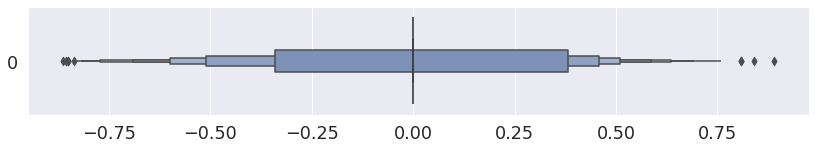

In [36]:
sentiment_triples = []
for triple in df_triples.columns:
    sentiment_triples.append(analyzer.polarity_scores(triple)['compound'])
plt.subplots(figsize=(14, 2))
sns.boxenplot(sentiment_triples, orient='h')

In [37]:
document_threshold = 50
column_selector = (df_triples > 0).sum() > document_threshold
df_triples_unsupervised = df_triples.iloc[:, np.array(column_selector)]
df_triples_unsupervised_len = len(df_triples_unsupervised.columns)
print('{}/{} triples occurring in more than {} documents'.format(df_triples_unsupervised_len, len(df_triples.columns), document_threshold))

591/5598 triples occurring in more than 50 documents


<AxesSubplot: >

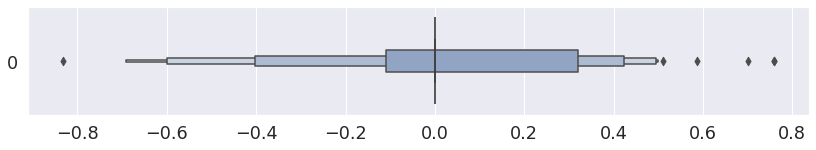

In [38]:
sentiment_triples = []
for triple in df_triples_unsupervised.columns:
    sentiment_triples.append(analyzer.polarity_scores(triple)['compound'])
plt.subplots(figsize=(14, 2))
sns.boxenplot(sentiment_triples, orient='h')

In [39]:
max_document_percentage = .1
n_documents = len(df_triples)
column_selector = (df_triples_unsupervised > 0).sum() > int(max_document_percentage * n_documents)
df_triples_unsupervised.iloc[:, np.array(column_selector)].columns

Index(['government-organization govern',
       'government-organization govern country', 'person have-org-role',
       'person have-org-role country',
       'person have-org-role government-organization', 'person have-rel-role',
       'person have-rel-role person', 'person research', 'person work'],
      dtype='object')

In [40]:
max_document_percentage = .1
n_documents = len(df_triples)
column_selector = (df_triples_unsupervised > 0).sum() < int(max_document_percentage * n_documents)
df_triples_unsupervised = df_triples_unsupervised.iloc[:, np.array(column_selector)]
print('{}/{} triples occurring in more than {} documents'.format(len(df_triples_unsupervised.columns), df_triples_unsupervised_len, document_threshold))
df_triples_unsupervised_len = len(df_triples_unsupervised.columns)

582/591 triples occurring in more than 50 documents


In [70]:
within_document_threshold = 2
document_threshold_2 = 10
column_selector = (df_triples_unsupervised > within_document_threshold).sum() > document_threshold_2
df_triples_unsupervised = df_triples_unsupervised.iloc[:, np.array(column_selector)]
print('{}/{} triples occurring more than {} times in {} documents'.format(len(df_triples_unsupervised.columns), df_triples_unsupervised_len, 
                                                                              within_document_threshold, document_threshold_2))

94/582 triples occurring more than 2 times in 10 documents


<AxesSubplot: >

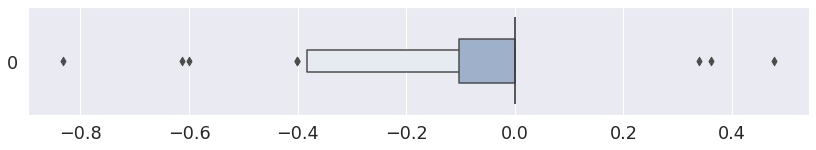

In [71]:
sentiment_triples = []
for triple in df_triples_unsupervised.columns:
    sentiment_triples.append(analyzer.polarity_scores(triple)['compound'])
plt.subplots(figsize=(14, 2))
sns.boxenplot(sentiment_triples, orient='h')

In [41]:
frame_idxs = np.where(sentiment_triples)[0]
print('{}/{} triples with non-neutral sentiment'.format(len(frame_idxs), len(sentiment_triples)))
df_triples_unsupervised_nonneutral = df_triples_unsupervised.iloc[:, frame_idxs]

90/591 triples with non-neutral sentiment


In [42]:
sentiment_triples_nonneutral = np.array(sentiment_triples)[frame_idxs]
#frame_idxs_nonneutral = np.argsort(sentiment_triples_nonneutral)[::-1]
frame_idxs_nonneutral = np.argsort((df_triples_unsupervised_nonneutral > 0).sum())[::-1]
for frame, sentiment, percentage in zip(
    df_triples_unsupervised_nonneutral.columns[frame_idxs_nonneutral],
    sentiment_triples_nonneutral[frame_idxs_nonneutral],
    (df_triples_unsupervised_nonneutral.iloc[:,frame_idxs_nonneutral] > 0).sum() / 100
):
    if sentiment != 0:
        #print("{:-<65} {}".format(frame, sentiment))
        print("{: <20} & {:5.2f} & {:5.2f} \\\\".format(frame, sentiment, percentage))

person have-org-role political-party &  0.48 &  6.22 \\
person study         & -0.34 &  6.16 \\
person author        & -0.48 &  3.82 \\
disease cause die    & -0.60 &  3.72 \\
person write         & -0.10 &  3.07 \\
we live              &  0.51 &  2.84 \\
person invest        &  0.40 &  2.76 \\
person play          & -0.10 &  2.52 \\
we do thing          &  0.44 &  2.46 \\
person judge         &  0.30 &  2.09 \\
person think         &  0.40 &  2.02 \\
you do thing         &  0.38 &  1.98 \\
person theorize conspire & -0.54 &  1.89 \\
disease cause die person & -0.60 &  1.82 \\
we work              &  0.32 &  1.72 \\
person deal          & -0.54 &  1.58 \\
organization report  &  0.44 &  1.54 \\
you see thing        &  0.38 &  1.52 \\
organization meet    &  0.38 &  1.46 \\
person comment       &  0.49 &  1.41 \\
person rebel         & -0.40 &  1.33 \\
we act               & -0.40 &  1.30 \\
person have-org-role and & -0.40 &  1.27 \\
person decide        & -0.38 &  1.24 \\
you see and 

# Analysis of Individual Frames

In [43]:
def plot_wordcloud(dataframe, dataframe_triples, frame, subcorpus=None):
    article_idxs = np.where(dataframe_triples[frame])[0]
    dataframe = df.iloc[article_idxs]
    if subcorpus:
        text = '\n\n'.join(dataframe.txt[dataframe.subcorpus == subcorpus])
    else:
        text = '\n\n'.join(dataframe.txt)

    # Create and generate a word cloud image:
    stopwords = STOPWORDS
    stopwords.update([
        'said',
        'will',
        's',
        'one',
        'u',
        'say'
    ])
    wordcloud = WordCloud(
        stopwords=stopwords,
        background_color='white',
    ).generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    return wordcloud

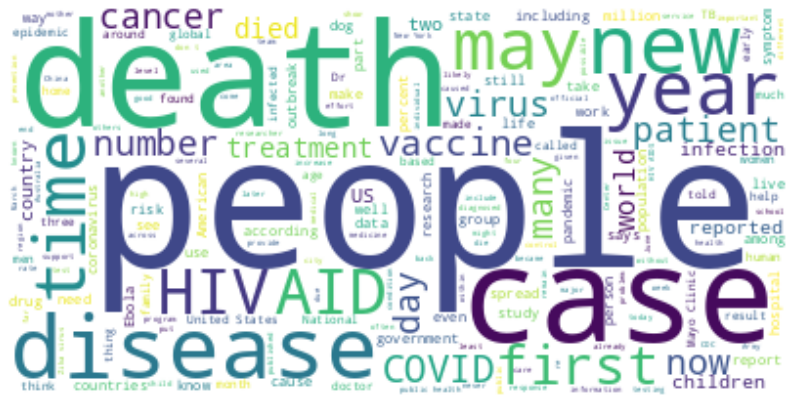

In [46]:
wordcloud = plot_wordcloud(df, df_triples_unsupervised_nonneutral, 'disease cause die', subcorpus='mainstream')
# with open('figures/wordcloud_mainstream.svg', 'w') as f:
#     f.write(wordcloud.to_svg())

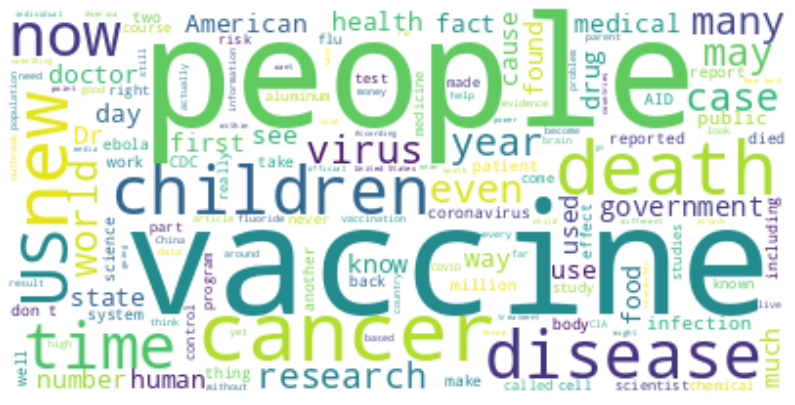

In [47]:
wordcloud = plot_wordcloud(df, df_triples_unsupervised_nonneutral, 'disease cause die', subcorpus='conspiracy')
# with open('figures/wordcloud_conspiracy.svg', 'w') as f:
#     f.write(wordcloud.to_svg())

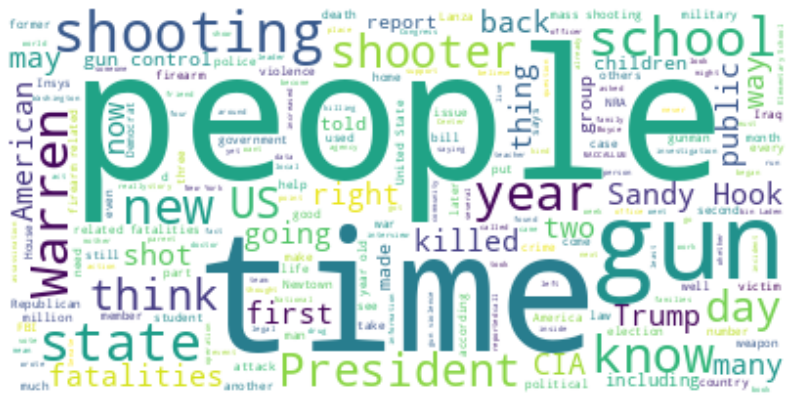

In [48]:
wordcloud = plot_wordcloud(df, df_triples_unsupervised_nonneutral, 'person shoot', subcorpus='mainstream')
# with open('figures/wordcloud_conspiracy.svg', 'w') as f:
#     f.write(wordcloud.to_svg())

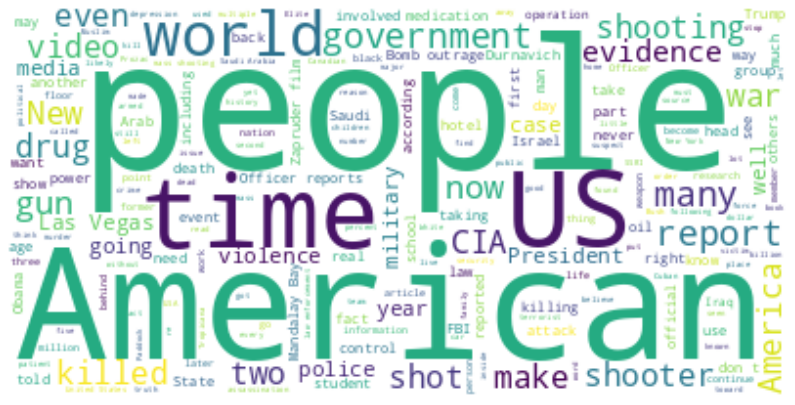

In [49]:
wordcloud = plot_wordcloud(df, df_triples_unsupervised_nonneutral, 'person shoot', subcorpus='conspiracy')
# with open('figures/wordcloud_conspiracy.svg', 'w') as f:
#     f.write(wordcloud.to_svg())

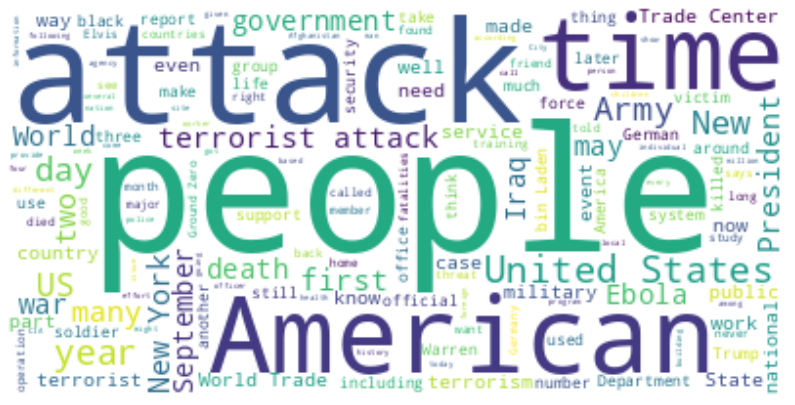

In [50]:
wordcloud = plot_wordcloud(df, df_triples_unsupervised_nonneutral, 'terrorist attack', subcorpus='mainstream')
# with open('figures/wordcloud_conspiracy.svg', 'w') as f:
#     f.write(wordcloud.to_svg())

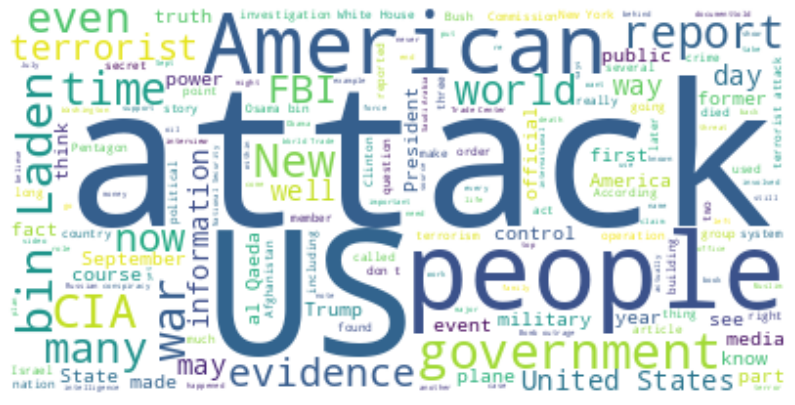

In [51]:
wordcloud = plot_wordcloud(df, df_triples_unsupervised_nonneutral, 'terrorist attack', subcorpus='conspiracy')
# with open('figures/wordcloud_conspiracy.svg', 'w') as f:
#     f.write(wordcloud.to_svg())

## BERTopic

In [85]:
frame = 'terrorist attack'
article_idxs = np.where(df_triples_unsupervised_nonneutral[frame])[0]
dataframe = df.iloc[article_idxs]
mainstream_texts = dataframe[dataframe.subcorpus == 'mainstream'].txt.to_numpy()
conspiracy_texts = dataframe[dataframe.subcorpus == 'conspiracy'].txt.to_numpy()

In [86]:
%%time
sentence_model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")
mainstream_embeddings = sentence_model.encode(mainstream_texts)
conspiracy_embeddings = sentence_model.encode(conspiracy_texts)

CPU times: user 1min 56s, sys: 798 ms, total: 1min 56s
Wall time: 26.6 s


In [87]:
from nltk.corpus import stopwords
vectorizer_model = CountVectorizer(stop_words=stopwords.words('english'))
topic_model = BERTopic(vectorizer_model=vectorizer_model)

In [88]:
%%time
topic_model.fit(mainstream_texts, mainstream_embeddings)
topic_model.get_topics()

CPU times: user 3.59 s, sys: 4.39 ms, total: 3.59 s
Wall time: 2.79 s


{-1: [('people', 0.024784062763332372),
  ('ebola', 0.023314239325423296),
  ('us', 0.022202389558818585),
  ('army', 0.021700353246997928),
  ('attacks', 0.018595071236600008),
  ('blood', 0.018124020815604564),
  ('states', 0.01787439028991879),
  ('also', 0.017193591163483343),
  ('said', 0.01715175763214355),
  ('united', 0.01708869340228495)],
 0: [('us', 0.030314755975581795),
  ('said', 0.02752667934248254),
  ('terrorist', 0.019658128183907615),
  ('would', 0.019341819258683213),
  ('one', 0.01893657216789384),
  ('states', 0.01887650045014524),
  ('attacks', 0.018558834531937442),
  ('american', 0.017677093227853376),
  ('security', 0.01700757164750319),
  ('could', 0.016924941378540715)],
 1: [('new', 0.03684623797834042),
  ('911', 0.034823817651629355),
  ('11', 0.03421581896191044),
  ('september', 0.03341039524591811),
  ('people', 0.033373272339483666),
  ('york', 0.032249252832342014),
  ('world', 0.03139843061119748),
  ('trade', 0.02953106990214353),
  ('center', 0.02

In [89]:
%%time
topic_model.fit(conspiracy_texts, conspiracy_embeddings)
topic_model.get_topics()

CPU times: user 3.4 s, sys: 3.39 ms, total: 3.4 s
Wall time: 2.75 s


{-1: [('911', 0.032575936762184864),
  ('us', 0.031595080933917497),
  ('one', 0.02142483595857975),
  ('people', 0.02125977569410156),
  ('attacks', 0.021204680411122948),
  ('would', 0.02042932167998434),
  ('world', 0.01953367730678384),
  ('government', 0.018741228741374485),
  ('war', 0.017824991897437723),
  ('new', 0.017536249067799183)]}

## Manual Inspection

In [84]:
article_idxs = np.where(df_triples_unsupervised_nonneutral['person shoot'])[0]
for idx in article_idxs:
    if df.subcorpus[idx] == 'conspiracy':
        print(df.txt[idx])
        print()
            #print(len(df.amr_penman[idx]))
            #print(extract_frames_document(df.amr_penman[idx]))
            #print()
            # pm = df.amr_penman[idx][61]
            # pm = re.sub(f'^# ::snt[^A-Za-z]+', '# ::snt ', pm)
            # pm = re.sub(f'(\r\n)+', '', pm)
            # graph = penman.decode(pm)
            # print(extract_frames(graph))
        input()
            # break

50+ dead and 53 injured in last night’s Islamic terror attack in Orlando, Florida

When you add up the numbers, a very disturbing picture of Obama’s presidency begins to unfold. He was elected as the “racial uniter”, the Nobel Peace Prize president who was going to“stop the rise of the oceans” and “heal our planet.”

Yet his 7 and one half years of occupying the desk at 1600 Pennsylvania Avenue hide a sinister statistic – America has had 23 mass shootings since he became president, and today’s mass killing in Orlando now brings that total to 24. And since this is a list of shootings only, it does not include the Boston Bombing Massacre that Obama used to roll out martial law for a 24-hour period in Boston. How do you explain that?

If you think of any we have missed in this list, please include it in the comment section below.

June 12, 2016 – Orlando, FL – 50+ dead, 53 injured. The gunman who slaughtered at least 50 people after taking party-goers hostage inside a gay club in Orlando 

It’s not healthy to go outside when someone from the Deep State is convicted of any wrongdoing. Something somewhere can happen to arrest the headlines of the day.

Cardinal George Pell is an Australian prelate of the Catholic Church, and more significantly, the man in charge of the Vatican Bank.

He is the highest ranking pedophile who was just convicted of the most heinous crime of our time, i.e. raping children, a few days ago, which led to the Pope calling for a Summit of Pedophiles, as we call it, to project to the world that they are indeed atoning for their sins.

Still, somehow, the Deep State saw the need to replace the headlines because remembering Michael Jackson wasn’t good enough.

Brenton Tarrant’s justification for his highly condemnable act simply doesn’t make any sense at all, and that’s the whole idea.

Australians, or the White Man in general, and Donald Trump in particular, are now being sold as the bad guys in such a manner as to provoke a race war. Because the Deep

A video has surfaced on the Internet showing private security contractors working for Aegis Defense Services “Victory” Group firing indiscriminately at Iraqi civilian motorists in Baghdad.

Since the news has been released, acknowledged by the mainstream British press, including The Telegraph (see article below), the video has been removed.from the Aegis co Iraq website

TO VIEW THE ORIGINAL VIDEO CLIP CLICK HERE 



WMV (Windows)

we bring to the attention of Global Research readers the following documents:

1. A statement by the Aegis Iraq Co following the removal of the video clip

2. A prior statement of Lieutenant Colonel Tim Spicer, OBE, CEO of Aegis

3. Review article by Wayne Madsen

4. The text of the article in London Daily Telegraph.

Following the removal of the Video clip, The following message was posted on the MESSAGE BOARD of Aegis Co Iraq at: 

 

http://www.aegisiraq.co.uk/Message_Board.htm

From: Andrew Joscelyne

Sent: 12 October 2005 17:08

To: All Baghdad; All Bas

The tangled web surrounding the Las Vegas massacre and the upheaval in Saudi Arabia have a common thread that just got yanked.

Below is the continuation into the connection on both sides of our globe following the money, the oil and the blood trail.

Saudi Arabia’s King to ‘stand down and hand power to son after purging’ rivals

KING Salman is reportedly preparing to make his son Prince Mohammed bin Salman the ruler of Saudi Arabia in a shock move following a corruption purge, reports claim. – Express.co

News of the purge came in the early hours of this morning after King Salman decreed the creation of an anti-corruption committee chaired by the 32-year-old Crown Prince, who has amassed power since rising from obscurity less than three years ago.

The new body was given broad powers to investigate cases, issue arrest warrants and travel restrictions and freeze assets.

The news comes after the US promised to aid Saudi Arabia in neutralising “Iran’s destabilising influence” and battle

KeyboardInterrupt: Interrupted by user

In [173]:
article_idxs = np.where(df_triples_unsupervised_nonneutral['disease cause die'])[0]
for idx in article_idxs:
    if df.subcorpus[idx] == 'conspiracy':
        print(df.txt[idx])
        print()
        #print(len(df.amr_penman[idx]))
        print(extract_frames_document(df.amr_penman[idx]))
        print()
        pm = df.amr_penman[idx][61]
        pm = re.sub(f'^# ::snt[^A-Za-z]+', '# ::snt ', pm)
        pm = re.sub(f'(\r\n)+', '', pm)
        graph = penman.decode(pm)
        print(extract_frames(graph))
        # input()
        break

Although the medical workers’ reaction to the mass genocide is painstakingly slow, they are reacting in such a way that should wake up a lot of people.

We are now seeing doctors sharing their own murderous experience alongside Big Pharma, bravely confirming “conspiracy theories” about an elaborate global depopulation program spearheaded by governing bodies such as the World Health Organization, in collusion with the top industrial chemical cartel namely Bayer and Dow Chemicals and their subsidiary drug companies.
• Medical Over-Treatment: 3rd Leading Cause of Death in U.S.

Contrary to what the mainstream media is saying, those who are claiming dangers within the medical industry are themselves authorities in the medical practice and have made their own extensive studies.

Criminal activities of this magnitude cannot remain hidden for all time.

“(NaturalNews) These following doctors were not content with half-truths, propaganda, and lies. They did their own research.

Dr. Banks earne

# Mutual Information

In [44]:
frame_idxs = np.where(sentiment_triples)[0]
df_triples_unsupervised_valence = df_triples_unsupervised.iloc[:,frame_idxs]
n_narratives = (df_triples_unsupervised_valence > 0).sum()
n_frames     = df_frames.sum()
unsup_frame_cooccurrences = (df_triples_unsupervised_valence > 0).to_numpy().T.dot(df_frames.to_numpy())

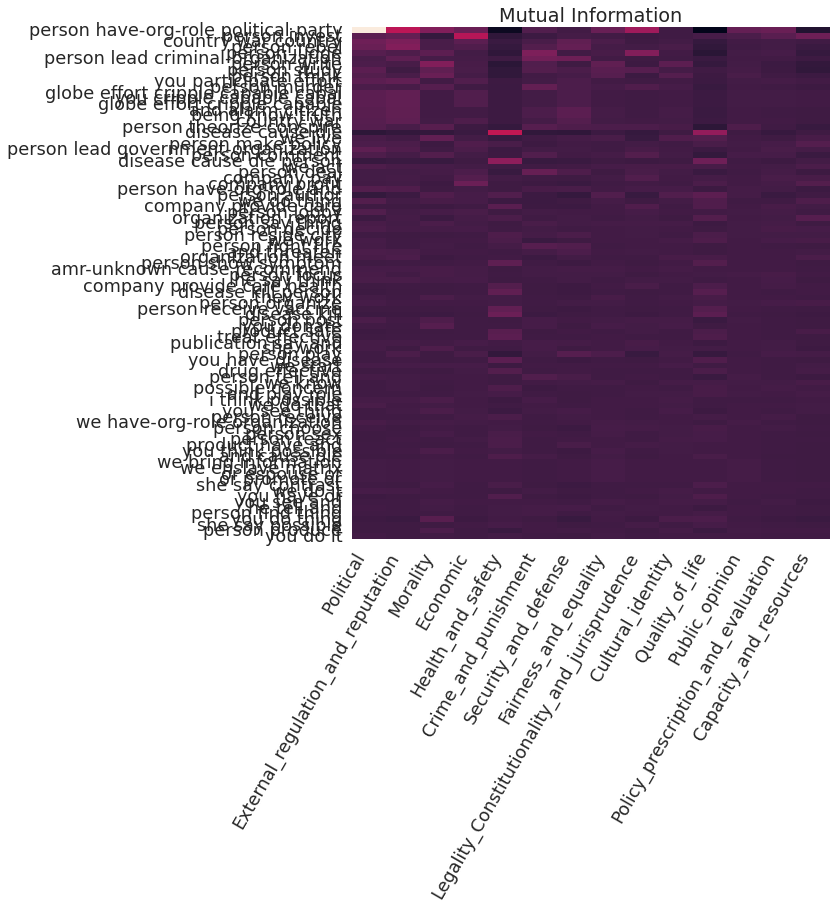

In [45]:
mutual_information_matrix = (unsup_frame_cooccurrences / n_documents) * np.log(((unsup_frame_cooccurrences * n_documents + 1).T / n_narratives.to_numpy()).T / n_frames.to_numpy())
order = np.argsort(mutual_information_matrix.sum(axis=1))[::-1]
order_frames = np.argsort(mutual_information_matrix.sum(axis=0))[::-1]
sns.set(font_scale=1.6)
fig, ax = plt.subplots(figsize=(12, 13))
heatmap = sns.heatmap(
    mutual_information_matrix[order].T[order_frames].T,
    xticklabels=np.array(categories)[order_frames],
    yticklabels=df_triples_unsupervised_valence.columns[order],
    cbar=False,
)
heatmap.set(title='Mutual Information')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=60, horizontalalignment='right')
plt.tight_layout()
#plt.savefig('figures/unsupervised_frames_mutual_information.pdf')

<AxesSubplot: >

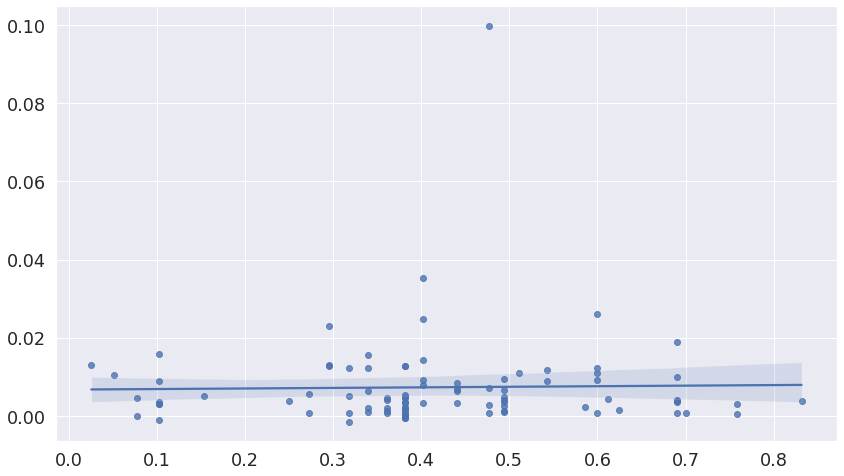

In [57]:
sns.regplot(x=np.abs(sentiment_triples_nonneutral), y=mutual_information_matrix.sum(axis=1))

# Conspiracy vs Mainstream

In [53]:
n_conspiracy = (df.subcorpus == 'conspiracy').sum()
n_mainstream = (df.subcorpus == 'mainstream').sum()

In [54]:
frame_idxs = np.where(sentiment_triples)[0]

selector = df.subcorpus == 'mainstream'
frame_counts = (df_triples_unsupervised[selector].iloc[:,frame_idxs] > 0).sum(axis=0)
frame_counts /= n_mainstream

selector = df.subcorpus == 'conspiracy'
frame_counts_con = (df_triples_unsupervised[selector].iloc[:,frame_idxs] > 0).sum(axis=0)
frame_counts_con /= n_conspiracy

df_relative_frame_counts = pd.DataFrame([frame_counts, frame_counts_con], index=['Mainstream', 'Conspiracy']).T

<AxesSubplot: xlabel='Frame %', ylabel='Frame'>

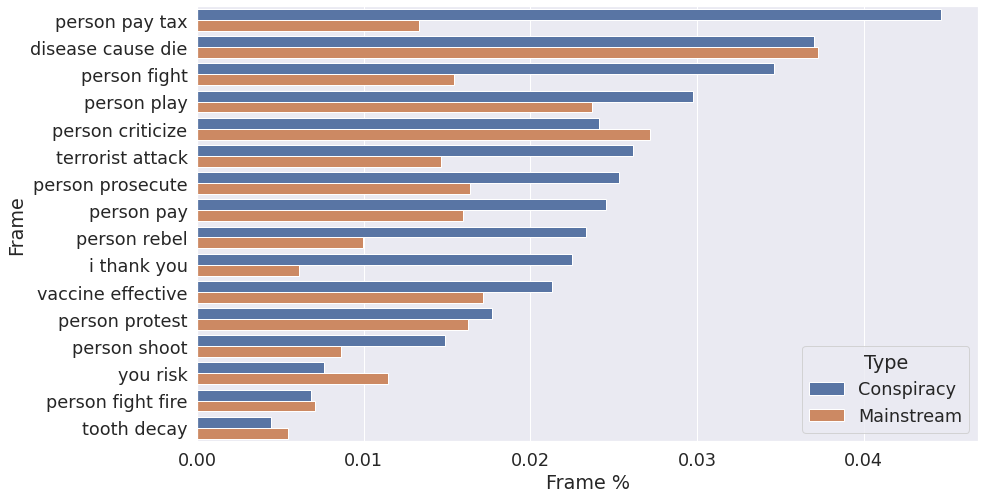

In [55]:
df_relative_frame_counts['Frame'] = df_relative_frame_counts.index
sns.barplot(
    df_relative_frame_counts.melt(id_vars='Frame', value_name='Frame %', var_name='Type').sort_values(by='Frame %', ascending=False),
    x='Frame %',
    y='Frame',
    hue='Type',
    
)

In [56]:
frame_idxs = np.where(sentiment_triples)[0]

selector = df.subcorpus == 'mainstream'
frame_counts = (df_triples_unsupervised[selector].iloc[:,frame_idxs] > 0).sum(axis=0)

selector = df.subcorpus == 'conspiracy'
frame_counts_con = (df_triples_unsupervised[selector].iloc[:,frame_idxs] > 0).sum(axis=0)

In [57]:
p_values = []
for c, c_con in zip(frame_counts, frame_counts_con):
    p_values.append(fisher_exact([[c, n_mainstream-c], [c_con, n_conspiracy-c_con]])[1])

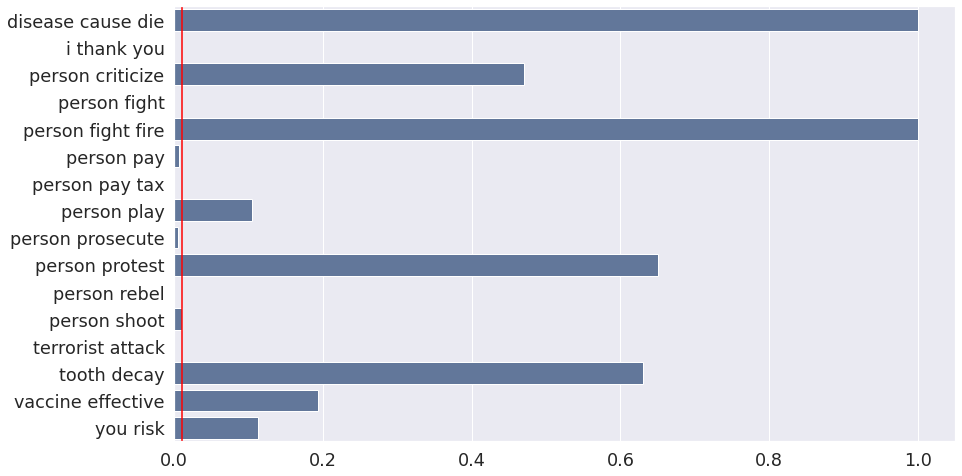

In [214]:
sns.barplot(y=df_triples_unsupervised.columns[frame_idxs], x=p_values, orient='h', color='#62779a', saturation=1.)
plt.axvline(0.01, c='red')
plt.show()

# Testing

In [85]:
print(df.iloc[0].amr_top_triples[0])
print(df.iloc[0].amr_instances[0])
print(df.iloc[0].amr_penman[0])

('person', 'say-01', 'find-02')
['say-01', 'person', 'name', 'have-org-role-91', 'president', 'find-02', 'fault-02', 'test-01', 'small-molecule', 'name', 'after', 'sample-01', 'and', 'goat', 'sheep', 'pawpaw', 'fruit', 'positive']
# ::snt President Magufuli says tests were found to be faulty after goat, sheep and pawpaw[fruit] samples test positive for COVID-19.
(s / say-01
      :ARG0 (p / person
            :name (n / name
                  :op1 "Magufuli")
            :ARG0-of (h / have-org-role-91
                  :ARG2 (p2 / president)))
      :ARG1 (f / find-02
            :ARG1 (f2 / fault-02
                  :ARG1 (t / test-01
                        :ARG2 (s2 / small-molecule
                              :name (n2 / name
                                    :op1 "COVID-19"))
                        :time (a / after
                              :ARG1 (s3 / sample-01
                                    :ARG1 (a2 / and
                                          :op1 (g / goat)


In [93]:
pm = df.iloc[0].amr_penman[0]
penman.decode(pm).instances()

[Instance(source='s', role=':instance', target='say-01'),
 Instance(source='p', role=':instance', target='person'),
 Instance(source='n', role=':instance', target='name'),
 Instance(source='h', role=':instance', target='have-org-role-91'),
 Instance(source='p2', role=':instance', target='president'),
 Instance(source='f', role=':instance', target='find-02'),
 Instance(source='f2', role=':instance', target='fault-02'),
 Instance(source='t', role=':instance', target='test-01'),
 Instance(source='s2', role=':instance', target='small-molecule'),
 Instance(source='n2', role=':instance', target='name'),
 Instance(source='a', role=':instance', target='after'),
 Instance(source='s3', role=':instance', target='sample-01'),
 Instance(source='a2', role=':instance', target='and'),
 Instance(source='g', role=':instance', target='goat'),
 Instance(source='s4', role=':instance', target='sheep'),
 Instance(source='p3', role=':instance', target='pawpaw'),
 Instance(source='f3', role=':instance', target

In [101]:
children = penman.decode(pm).edges(source='p')
if children:
    assert len(children) == 1
    if children[0].role == ':name':
        name = penman.decode(pm).attributes(source=children[0].target)[0].target
print(name)

"Magufuli"


In [95]:
penman.decode(pm).attributes()

[Attribute(source='n', role=':op1', target='"Magufuli"'),
 Attribute(source='n2', role=':op1', target='"COVID-19"')]

In [94]:
penman.decode(pm).edges()

[Edge(source='s', role=':ARG0', target='p'),
 Edge(source='p', role=':name', target='n'),
 Edge(source='h', role=':ARG0', target='p'),
 Edge(source='h', role=':ARG2', target='p2'),
 Edge(source='s', role=':ARG1', target='f'),
 Edge(source='f', role=':ARG1', target='f2'),
 Edge(source='f2', role=':ARG1', target='t'),
 Edge(source='t', role=':ARG2', target='s2'),
 Edge(source='s2', role=':name', target='n2'),
 Edge(source='t', role=':time', target='a'),
 Edge(source='a', role=':ARG1', target='s3'),
 Edge(source='s3', role=':ARG1', target='a2'),
 Edge(source='a2', role=':op1', target='g'),
 Edge(source='a2', role=':op2', target='s4'),
 Edge(source='a2', role=':op3', target='p3'),
 Edge(source='p3', role=':mod', target='f3'),
 Edge(source='s3', role=':ARG2', target='p4'),
 Edge(source='a', role=':op1', target='t')]

In [ ]:
# ARG0
penman.decode(pm)._filter_triples(source='p', role=':instance', target=None)

[('p', ':instance', 'person')]

In [ ]:
# Predicate
penman.decode(pm)._filter_triples(source='s', role=':instance', target=None)

[('s', ':instance', 'say-01')]

In [ ]:
penman.decode(pm).edges(source='s')

[Edge(source='s', role=':ARG0', target='p'),
 Edge(source='s', role=':ARG1', target='f')]

In [ ]:
# ARG1
penman.decode(pm)._filter_triples(source='f', role=':instance', target=None)

[('f', ':instance', 'find-02')]

In [ ]:
penman.decode(pm).edges(role=':ARG1')

[Edge(source='s', role=':ARG1', target='f'),
 Edge(source='f', role=':ARG1', target='f2'),
 Edge(source='f2', role=':ARG1', target='t'),
 Edge(source='a', role=':ARG1', target='s3'),
 Edge(source='s3', role=':ARG1', target='a2')]

In [ ]:
all_triples = []
for l in df.amr_top_triples:
    all_triples.extend(l)

In [ ]:
unique_triples = {}
for triple in all_triples:
    if triple in unique_triples:
        unique_triples[triple] += 1
    else:
        unique_triples[triple] = 1
unique_triples = dict(sorted(unique_triples.items(), key=lambda item: item[1], reverse=True))

[Text(0.5, 1.0, 'Distribution of Triple Counts')]

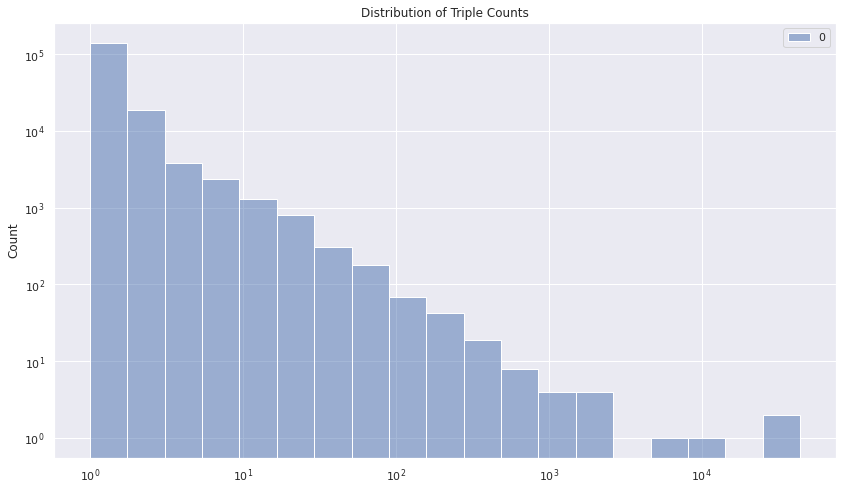

In [ ]:
sns.histplot(unique_triples.values(), log_scale=(True, True)).set(title='Distribution of Triple Counts')

In [ ]:
print(len(unique_triples), 'triples')
print(np.sum(np.array(list(unique_triples.values())) > 10), 'that occur more than 10 times')

169340 triples
2442 that occur more than 10 times


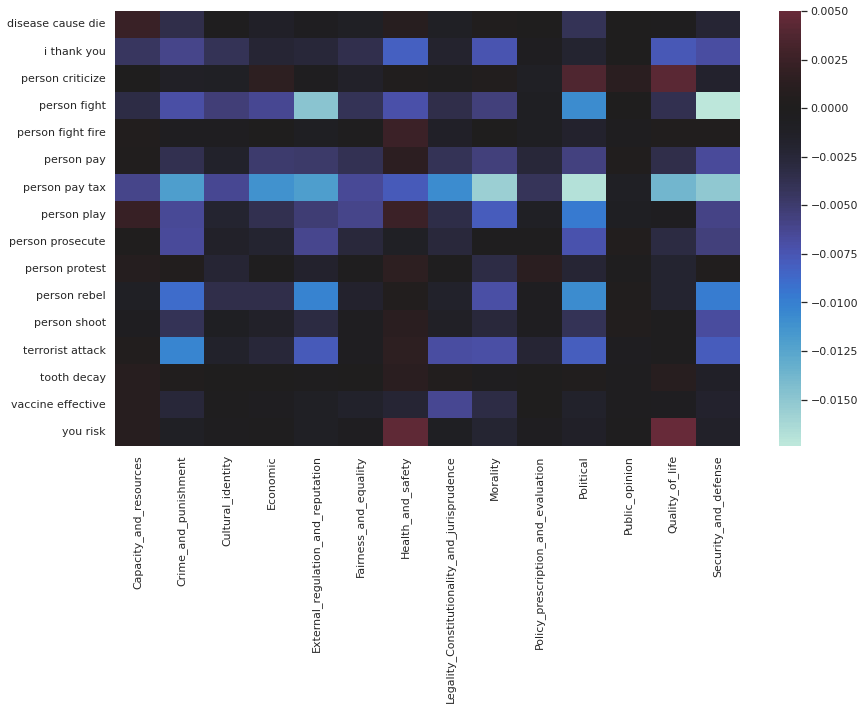

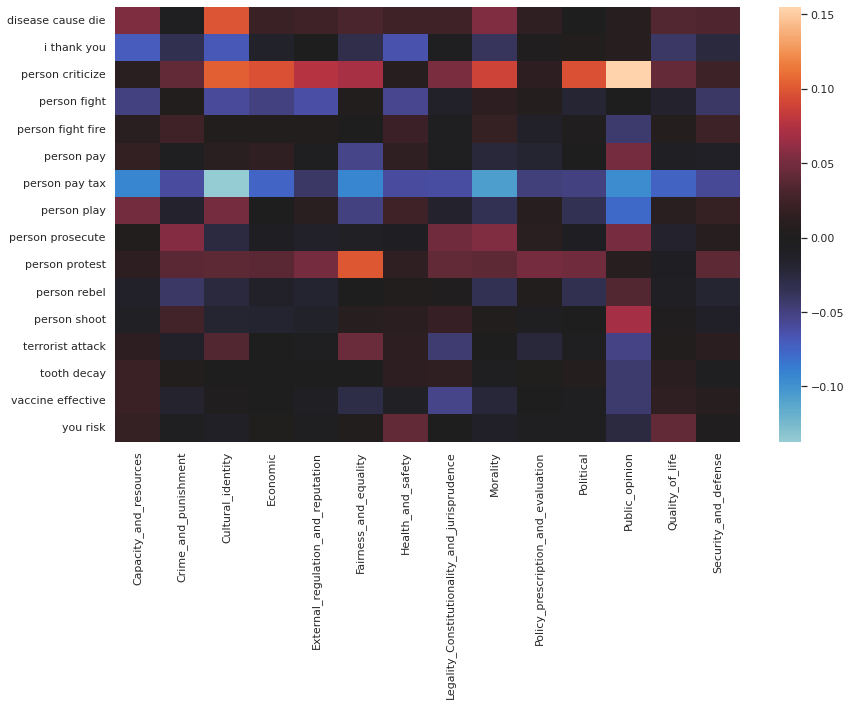

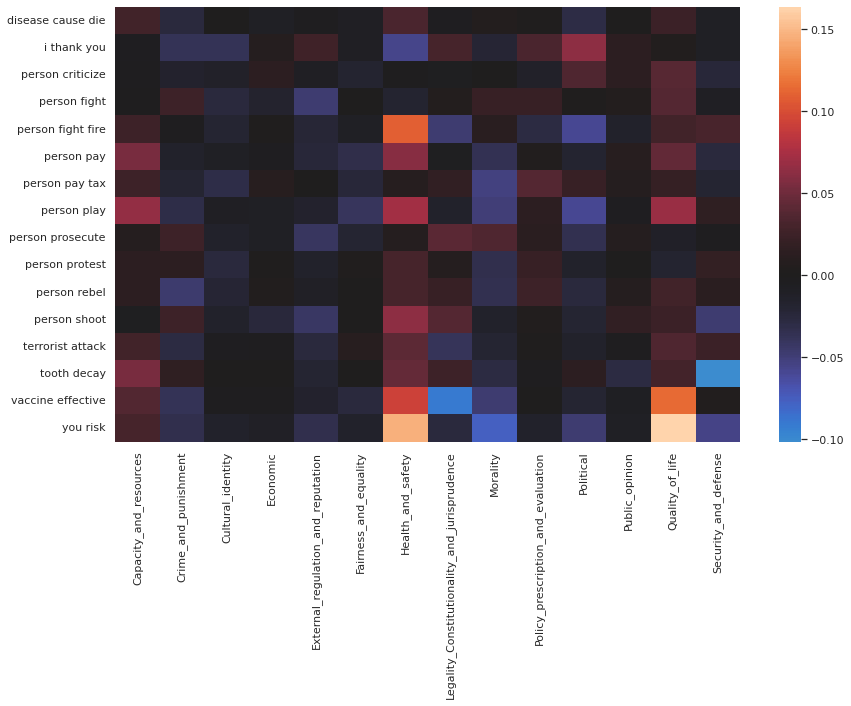

In [113]:
selector_c = df.subcorpus == 'conspiracy'
unsup_frame_cooccurrences_conspiracy = (df_triples_unsupervised[selector_c].iloc[:,frame_idxs] > 0).to_numpy().T.dot(df_frames[selector_c].to_numpy())
selector_m = df.subcorpus == 'mainstream'
unsup_frame_cooccurrences_mainstream = (df_triples_unsupervised[selector_m].iloc[:,frame_idxs] > 0).to_numpy().T.dot(df_frames[selector_m].to_numpy())

# relative amount of co-occurrences, influenced by number of frames as well as narratives
# in conspiracy media, the number of co-occurrences is on average higher
# however, conspiracy media uses more frames as well as more narratives
unsup_frame_cooccurrences_diff = unsup_frame_cooccurrences_mainstream / selector_m.sum() - \
                                 unsup_frame_cooccurrences_conspiracy / selector_c.sum()
sns.heatmap(
    unsup_frame_cooccurrences_diff,
    xticklabels=categories,
    yticklabels=df_triples_unsupervised.iloc[:,frame_idxs].columns,
    cmap=sns.color_palette("icefire", as_cmap=True),
    center=0
)
plt.show()

# 
unsup_frame_cooccurrences_diff = unsup_frame_cooccurrences_mainstream / unsup_frame_cooccurrences_mainstream.sum(axis=0) - \
                                 unsup_frame_cooccurrences_conspiracy / unsup_frame_cooccurrences_conspiracy.sum(axis=0)
sns.heatmap(
    unsup_frame_cooccurrences_diff,
    xticklabels=categories,
    yticklabels=df_triples_unsupervised.iloc[:,frame_idxs].columns,
    cmap=sns.color_palette("icefire", as_cmap=True),
    center=0
)
plt.show()

unsup_frame_cooccurrences_diff = (unsup_frame_cooccurrences_mainstream.T / unsup_frame_cooccurrences_mainstream.sum(axis=1)).T - \
                                 (unsup_frame_cooccurrences_conspiracy.T / unsup_frame_cooccurrences_conspiracy.sum(axis=1)).T
sns.heatmap(
    unsup_frame_cooccurrences_diff,
    xticklabels=categories,
    yticklabels=df_triples_unsupervised.iloc[:,frame_idxs].columns,
    cmap=sns.color_palette("icefire", as_cmap=True),
    center=0
)
plt.show()

<AxesSubplot: >

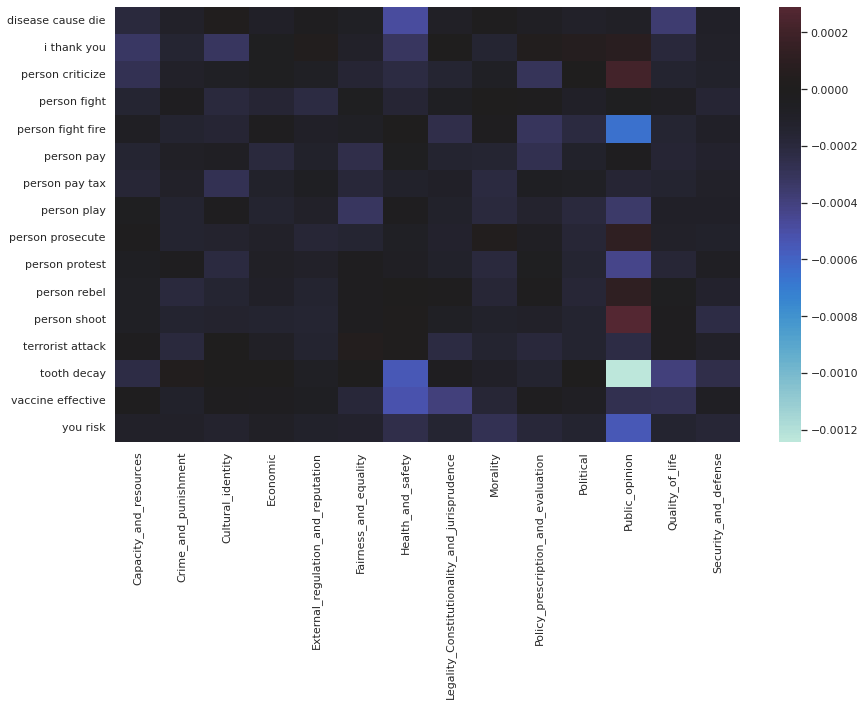

In [115]:
unsup_frame_cooccurrences_diff = (unsup_frame_cooccurrences_mainstream.T / unsup_frame_cooccurrences_mainstream.sum(axis=1)).T / unsup_frame_cooccurrences_mainstream.sum(axis=0) - \
                                 (unsup_frame_cooccurrences_conspiracy.T / unsup_frame_cooccurrences_conspiracy.sum(axis=1)).T / unsup_frame_cooccurrences_conspiracy.sum(axis=0)
sns.heatmap(
    unsup_frame_cooccurrences_diff,
    xticklabels=categories,
    yticklabels=df_triples_unsupervised.iloc[:,frame_idxs].columns,
    cmap=sns.color_palette("icefire", as_cmap=True),
    center=0
)